# Build NIDS with scikit-learn

The notebook is about how to build a simple Network-based intrusion detection system, we used scikit-learn as the machine learning library because of it's clear interface and powerful algorithms.


- Introduction
- Step 1: Get datasets
- Step 2: Preprocessing
  - Step 2.1: Binarization for label
  - Step 2.2: Encoding Categorical Features
  - Step 2.3: Standardization
  - Step 2.4: Normalization
  - Step 2.5: Training And Test Data
- Step 3: Training
  - Step 3.1: Training with LR
  - Step 3.2: Training with linear SVC
  - Step 3.3: Feature selection
  - Step 3.3.1: Feature selection with L1 regularization
  - Step 3.3.2: Feature importance with Random Forest
- Step 4: Prediction
- Step 5: Evaluation
  - Step 5.1: Evaluation for LogisticRegression
  - Step 5.2: Evaluation for RandomForest
  - Step 5.3: Evaluation for SVC
- Step 6: Dimensional reduction
- Step 7: Re-training
  - Step 7.1: Re-training: LR
  - Step 7.2: Re-training: RF
  - Step 7.3: Re-training: SVC
- Step 8: Re-Prediction
  - Step 8.1: Re-Prediction: LR
  - Step 8.2: Re-Prediction: RF
  - Step 8.3: Re-Prediction: SVC
- Step 9: Re-Evaluation
  - Step 9.1: Re-Evaluation for LR
  - Step 9.2: Re-Evaluation for RF
  - Step 9.3: Re-Evaluation for SVC
- Step 10: Eigendecomposition
- Step 11: Clustering

## Introduction

In [1]:
from IPython.display import Image

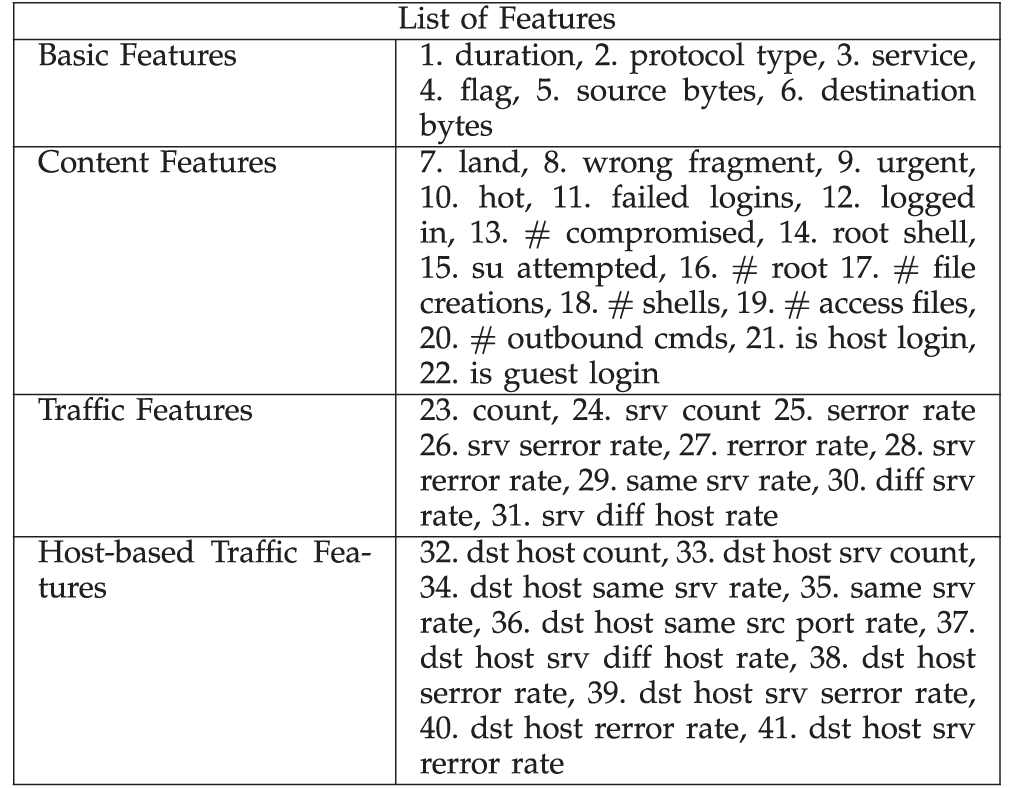

In [3]:

Image(filename='./images/list_of_features.gif', width=500)

In [ ]:
Image(filename='./images/list_of_features.gif', width=500)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


### Step 1: Get datasets

In [2]:
# get dataset from http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
NET_DATA_PATH = os.path.join("../datasets")


In [3]:
# get data from file
def load_datasets(data_path=NET_DATA_PATH):
    # 41 features , 1 label
    feature_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
                     "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                     "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                     "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                     "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                     "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                     "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                     "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                     "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                     "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
    data_file = os.path.join(data_path, "datasets_10")
    return pd.read_csv(data_file, header=None, names=feature_names)


In [4]:
def plot_features(X):
    # plot data
    # for index, classes in X.groupby('label'):
    #     print('class_{}'.format(index))
    #     print(classes)

    # attack_data = X[X['label'] == 1]                                  #for dataframe
    # normal_data = X[X['label'] == -1]                                 #for dataframe
    attack_data = X[X[:, -1] > 0]  # numpy
    normal_data = X[X[:, -1] < 0]  # numpy
    # print(attack_data)
    # print(normal_data)
    #
    # plt.scatter(attack_data.values[:200, 0], attack_data.values[:200, 1],         #dataframe
    #             color='red', marker='o', label='attack')
    # plt.scatter(normal_data.values[:200, 0], normal_data.values[:200, 1],            #dataframe
    #             color='blue', marker='x', label='normal')

    plt.scatter(attack_data[:, 0], attack_data[:, 1],  # numpy
                color='red', marker='o', label='attack traffics')
    plt.scatter(normal_data[:, 0], normal_data[:, 1],  # numpy
                color='blue', marker='x', label='normal traffics')

    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.legend(loc='upper left')

    plt.show()


In [5]:

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx],
                    label=cl)


In [6]:
data = load_datasets()
data = data.iloc[:25000, :]

# select top 2 features: srv_count, num_compromised
# data = datasets[['srv_count', 'num_compromised', 'label']]


# print(data.head())
# print(data.tail())

# print(data.info())

print(data['label'].value_counts())


normal.             21110
smurf.               3695
teardrop.              99
guess_passwd.          53
pod.                   20
portsweep.             17
buffer_overflow.        2
neptune.                2
loadmodule.             1
perl.                   1
Name: label, dtype: int64


### Step 2: Preprocessing

### Step 2.1: Binarization for label

In [7]:

# get label, last column, convert it to binary classification label
ori_labels = data.iloc[:,-1].values
data.iloc[:, -1] = np.where(data.iloc[:, -1] == 'normal.', -1, 1)
labels = data.iloc[:, -1].values
# labels = last_column.copy()
# labels[labels != 'normal.'] = 'attack.'               # dataframe
# print(labels.value_counts())                          # dataframe
# print(labels)


### Step 2.2: Encoding Categorical Features

In [8]:

# get features, Encoding Categorical Features for 3 features
data.sort_values('label')
enc = LabelEncoder()
data['service'] = enc.fit_transform(data['service'])
data['flag'] = enc.fit_transform(data['flag'])
data['protocol_type'] = enc.fit_transform(data['protocol_type'])

# features.astype(float)
# print(features.info())
# print(features['service'])


### Step 2.3: Standardization

In [10]:
std_data = StandardScaler().fit(data).transform(data)

### Step 2.4: Normalization

In [11]:
normalized_data = Normalizer().fit(std_data).transform(std_data)


### Step 2.5: Training And Test Data

In [14]:
# features = normalized_data.drop('label', axis=1)                  #dataframe
features = np.delete(normalized_data, -1, axis=1)
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.3,
                                                                    random_state=24)


### Step 3: Training

### Step 3.1: Training with LR

In [17]:

lr = LogisticRegression(C=1.0, penalty='l1', random_state=0)
lr.fit(train_data, train_labels)

# plot_decision_regions(train_data, train_labels, classifier=lr)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend(loc='upper left')
#
# plt.tight_layout()
# plt.show()


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Step 3.2: Training with linear SVC

In [18]:

svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=100.0)
# svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(train_data, train_labels)

#
# plot_decision_regions(train_data, train_labels, classifier=svm)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend(loc='upper left')
#
# plt.tight_layout()
# plt.show()


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

### Step 3.3: Feature selection

### Step 3.3.1: Feature selection with L1 regularization

In [20]:
print('Training accuracy:', lr.score(train_data, train_labels))
print('Test accuracy:', lr.score(train_data, train_labels))
print('Intercept:', lr.intercept_)
print('Model weights:', lr.coef_)


Training accuracy: 0.999771428571
Test accuracy: 0.999771428571
Intercept: [-3.442558]
Model weights: [[  0.          -5.72385499   0.           0.           0.           0.
    0.          11.9457327    0.           0.           7.3199053
   -4.63981077   0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.          14.26386929
    4.59001604   0.           0.           2.10442474   0.72455873
   -1.18770966   0.           0.           0.83811994   3.00262987   0.
    0.           0.           0.           0.64944708   3.94242612   0.
    5.11219074]]


### Step 3.3.2: Feature importance with Random Forest

In [21]:
names = data.columns[1:]
forest = RandomForestClassifier(n_estimators=10,
                                random_state=0,
                                n_jobs=-1)
forest.fit(train_data, train_labels)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
#
# for f in range(train_data.shape[1]):
#     print("%2d) %-*s %f" % (f + 1, 30,
#                             names[indices[f]],
#                             importances[indices[f]]))
#
# plt.title('Feature Importances')
# plt.bar(range(train_data.shape[1]),
#         importances[indices],
#         color='lightblue',
#         align='center')
#
# plt.xticks(range(train_data.shape[1]),
#            names[indices], rotation=90)
# plt.xlim([-1, train_data.shape[1]])
# plt.tight_layout()
# plt.show()


### Step 4: Prediction

In [22]:

pred_labels = lr.predict(test_data)
# print(pred_labels)

pred_labels_rf = forest.predict(test_data)
pred_labels_svc = svm.predict(test_data)


### Step 5: Evaluation

### Step 5.1: Evaluation for LogisticRegression

In [25]:

print('Accuracy for LogisticRegression: %.2f' % accuracy_score(test_labels, pred_labels))
print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels))


Accuracy for LogisticRegression: 1.00
             precision    recall  f1-score   support

         -1       1.00      1.00      1.00      6362
          1       1.00      0.99      1.00      1138

avg / total       1.00      1.00      1.00      7500

[[6361    1]
 [   6 1132]]


### Step 5.2: Evaluation for RandomForest

In [27]:

print('Accuracy for Random Forest: %.2f' % accuracy_score(test_labels, pred_labels_rf))
print(classification_report(test_labels, pred_labels_rf))
print(confusion_matrix(test_labels, pred_labels_rf))


Accuracy for Random Forest: 1.00
             precision    recall  f1-score   support

         -1       1.00      1.00      1.00      6362
          1       1.00      1.00      1.00      1138

avg / total       1.00      1.00      1.00      7500

[[6362    0]
 [   5 1133]]


### Step 5.3: Evaluation for SVC

In [29]:

print('Accuracy for Random Forest: %.2f' % accuracy_score(test_labels, pred_labels_rf))
print(classification_report(test_labels, pred_labels_rf))
print(confusion_matrix(test_labels, pred_labels_svc))


Accuracy for Random Forest: 1.00
             precision    recall  f1-score   support

         -1       1.00      1.00      1.00      6362
          1       1.00      1.00      1.00      1138

avg / total       1.00      1.00      1.00      7500

[[6361    1]
 [   3 1135]]


### Step 6: Dimensional reduction

In [31]:

pca = PCA(n_components=2)
pca_train_data = pca.fit_transform(train_data)
pca_test_data = pca.transform(test_data)  # no need fit again ?
print('Variance explained ratio:\n', pca.explained_variance_ratio_)



Variance explained ratio:
 [ 0.35563008  0.29324988]


### Step 7: Re-training

### Step 7.1: Re-training: LR

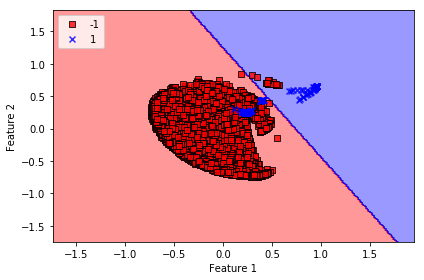

In [34]:

lr = LogisticRegression(C=0.1, random_state=1)
lr.fit(pca_train_data, train_labels)

plot_decision_regions(pca_train_data, train_labels, classifier=lr)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Step 7.2: Re-training: RF

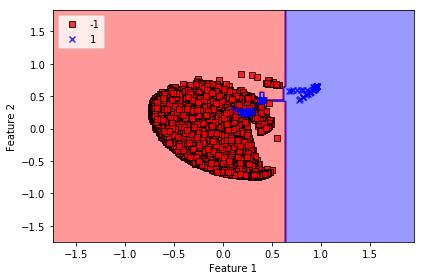

In [36]:

forest = RandomForestClassifier(n_estimators=10,
                                random_state=1,
                                n_jobs=-1)
forest.fit(pca_train_data, train_labels)


plot_decision_regions(pca_train_data, train_labels, classifier=forest)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Step 7.3: Re-training: SVC

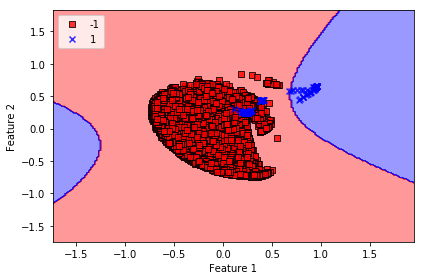

In [38]:

svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(pca_train_data, train_labels)

plot_decision_regions(pca_train_data, train_labels, classifier=svm)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


### Step 8: Re-Prediction

### Step 8.1: Re-Prediction: LR

In [41]:
pca_pred_labels = lr.predict(pca_test_data)


### Step 8.2: Re-Prediction: RF

In [43]:
pca_pred_labels_rf = forest.predict(pca_test_data)


### Step 8.3: Re-Prediction: SVC

In [45]:
pca_pred_labels_svc = svm.predict(pca_test_data)


### Step 9: Re-Evaluation

### Step 9.1: Re-Evaluation for LR

In [48]:

print('Accuracy for LR: %.2f' % accuracy_score(test_labels, pca_pred_labels))
print(classification_report(test_labels, pca_pred_labels))
print(confusion_matrix(test_labels, pca_pred_labels))


Accuracy for LR: 0.99
             precision    recall  f1-score   support

         -1       0.99      1.00      0.99      6362
          1       0.99      0.95      0.97      1138

avg / total       0.99      0.99      0.99      7500

[[6346   16]
 [  55 1083]]


### Step 9.2: Re-Evaluation for RF

In [50]:

print('Accuracy for RF: %.2f' % accuracy_score(test_labels, pca_pred_labels_rf))
print(classification_report(test_labels, pca_pred_labels_rf))
print(confusion_matrix(test_labels, pca_pred_labels_rf))


Accuracy for RF: 1.00
             precision    recall  f1-score   support

         -1       1.00      1.00      1.00      6362
          1       1.00      0.99      0.99      1138

avg / total       1.00      1.00      1.00      7500

[[6357    5]
 [  10 1128]]


### Step 9.3: Re-Evaluation for SVC

In [52]:

print('Accuracy for RF: %.2f' % accuracy_score(test_labels, pca_pred_labels_rf))
print(classification_report(test_labels, pca_pred_labels_rf))
print(confusion_matrix(test_labels, pca_pred_labels_rf))


Accuracy for RF: 1.00
             precision    recall  f1-score   support

         -1       1.00      1.00      1.00      6362
          1       1.00      0.99      0.99      1138

avg / total       1.00      1.00      1.00      7500

[[6357    5]
 [  10 1128]]


### Step 10: Eigendecomposition


Eigenvalues 
[  2.99114361e-01   2.46647445e-01   8.50126427e-02   5.29780334e-02
   4.75289654e-02   2.85475047e-02   1.88452658e-02   1.22841006e-02
   1.10857767e-02   5.40650502e-03   4.64356047e-03   4.04133932e-03
   3.68995540e-03   3.53475285e-03   2.91677072e-03   2.76153067e-03
   2.26727730e-03   1.74005980e-03   1.43924964e-03   1.23517339e-03
   1.06042316e-03   9.25037386e-04   7.01341056e-04   4.72990524e-04
   4.62231636e-04   4.33429036e-04   3.47228851e-04   2.43505405e-04
   2.63051126e-06   9.35090494e-06   5.70148567e-05   4.95794351e-05
   1.18869781e-04   1.65862646e-04   1.57514162e-04   1.55566328e-04
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


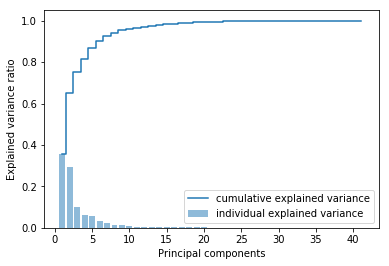

In [54]:

cov_mat = np.cov(train_data.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 42), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 42), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()


### Step 11: Clustering

In [57]:

k = 20
km = KMeans(n_clusters=k)
km.fit(train_data)
print(pd.Series(km.labels_).value_counts())

label_names = list(map(
    lambda x: pd.Series([ori_labels[i] for i in range(len(km.labels_)) if km.labels_[i] == x]),
    range(k)))

for i in range(k):
    print("Cluster {} labels:".format(i))
    print(label_names[i].value_counts())

2     2784
0     2608
6     2119
12    1614
8     1163
10     930
1      928
5      700
13     638
7      630
4      612
3      469
9      449
17     439
15     424
14     347
11     337
19     113
18     105
16      91
dtype: int64
Cluster 0 labels:
normal.        2055
smurf.          549
pod.              2
loadmodule.       1
neptune.          1
dtype: int64
Cluster 1 labels:
normal.    735
smurf.     192
pod.         1
dtype: int64
Cluster 2 labels:
normal.             2186
smurf.               588
pod.                   7
buffer_overflow.       1
perl.                  1
neptune.               1
dtype: int64
Cluster 3 labels:
normal.    360
smurf.     109
dtype: int64
Cluster 4 labels:
normal.    498
smurf.     113
pod.         1
dtype: int64
Cluster 5 labels:
normal.             549
smurf.              150
buffer_overflow.      1
dtype: int64
Cluster 6 labels:
normal.          1700
smurf.            416
pod.                2
guess_passwd.       1
dtype: int64
Cluster 7 labels:
no